In [123]:
# If you don't already have it...
#import sys
#!{sys.executable} -m pip install nflows
#!{sys.executable} -m pip install uproot

### Trying to flow from a Gaussian to the LHCb Log10(IP) shape

* The LHCb simulation Z->mu mu log10(IP) shape is almost Gaussian, but not quite, and the shape of the high IP tail is really important and hard to model.
* We want to flow from a Gaussian to there.
* The step after that would be to invert the flow (that is part of the properties of a normalising flow), from there to Gaussian.
* A similar flow should be able to flow from Gaussian -> Z IP data shape. 
* Thus you have a 2-step flow procedure of simulation -> Gaussian -> data, which is the transformation we want to learn.

In [124]:
# Let's first load up the simulated data and put it into a 1D numpy array
import numpy as np
import uproot

file = uproot.open("../data/tuple_for_training__DATA.root")
muon_prefix = "mup_"
branch = f'{muon_prefix}IP'
selection = "(1>0)"
sim_ip = file['DecayTree'].arrays(
    branch, cut=selection, library='np')[branch].astype(np.float64)

N_SAMPLES = 10000
sim_log10_ip = np.log10(sim_ip)
# take first N_SAMPLES from sim_log10_ip
sim_log10_ip = sim_log10_ip[:, :N_SAMPLES]
print(sim_log10_ip.shape)

(1, 10000)


In [125]:
import matplotlib.pyplot as plt

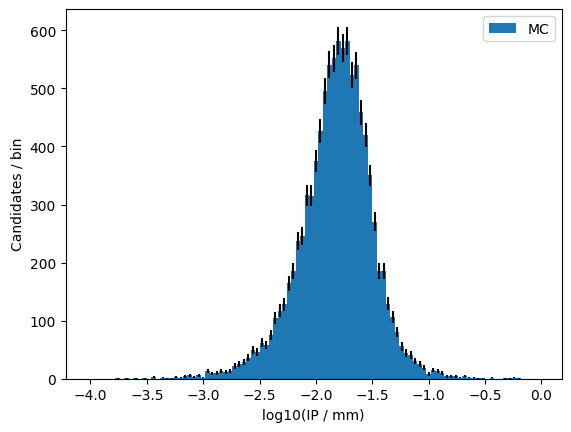

In [126]:
fig, ax = plt.subplots()
hist_mc, bins = np.histogram(sim_log10_ip, bins=100, range=(-4, 0))
bin_centers = (bins[:-1] + bins[1:]) / 2
ax.bar(x=bins[:-1], height=hist_mc, yerr=np.sqrt(hist_mc), width=bins[1] - bins[0], label='MC')
ax.set_xlabel('log10(IP / mm)')
ax.set_ylabel('Candidates / bin')
ax.legend()
plt.show()

Now we've got the data loaded in, and it looks about right.
Next step is just instance a 1D flow as before.

In [127]:
from nflows import transforms, distributions, flows
import torch

In [128]:
# Define an invertible transformation.
# Need to learn what these transforms do/why we might want to use these.
# This time it's a 1D transform, so just 1 input and output feature.
# Follow the tutorial example from the nflows package docs, we'll try a MaskedAffineAutoregressiveTransform
N_FEATURES = 1
transform = transforms.CompositeTransform([
    transforms.MaskedAffineAutoregressiveTransform(features=N_FEATURES, hidden_features=4),
    transforms.RandomPermutation(features=N_FEATURES)
])

# Define a base distribution.
base_distribution = distributions.StandardNormal(shape=[N_FEATURES])
print(base_distribution)

# Combine into a flow.
flow = flows.Flow(transform=transform, distribution=base_distribution)
print(flow)


StandardNormal()
Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=1, out_features=4, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x MaskedResidualBlock(
              (linear_layers): ModuleList(
                (0-1): 2 x MaskedLinear(in_features=4, out_features=4, bias=True)
              )
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=4, out_features=2, bias=True)
        )
      )
      (1): RandomPermutation()
    )
  )
  (_distribution): StandardNormal()
  (_embedding_net): Identity()
)


Let's take a look at the standard normal

<class 'torch.Tensor'>
torch.Size([1000, 1])
tensor([[ 1.9269],
        [ 1.4873],
        [ 0.9007],
        [-2.1055],
        [ 0.6784],
        [-1.2345],
        [-0.0431],
        [-1.6047],
        [-0.7521],
        [ 1.6487]])


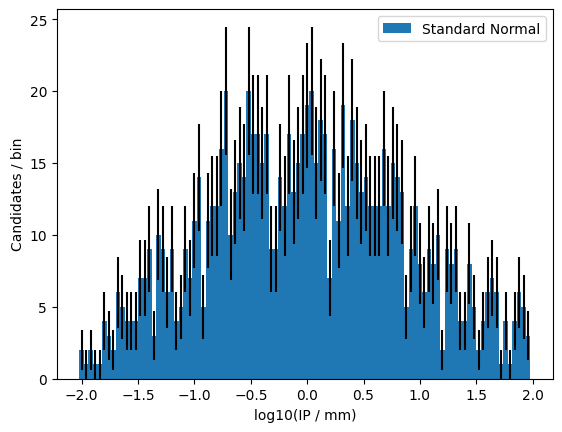

In [129]:
torch.manual_seed(42)
with torch.inference_mode():
    num_samples = 1000
    samples = base_distribution.sample(num_samples)
    print(type(samples))
    print(samples.shape)
    print(samples[:10])

    # Gotta plot them 
    normal_hist, norm_bins = np.histogram(samples, bins=100, range=(-2, 2))
    plt.bar(x=norm_bins[:-1], height=normal_hist, yerr=np.sqrt(normal_hist), width=norm_bins[1] - norm_bins[0], label='Standard Normal')
    plt.xlabel('log10(IP / mm)')
    plt.ylabel('Candidates / bin')
    plt.legend()
    plt.show()

Looks fairly Gaussian to me.
Let's try to train the flow.

First we'll need to make sure the target data is in the correct format for the training process.
I think we need to insert a batch dimension as the last dim, even though we're not batching just yet.

In [130]:
# Prepare the target data
# Reshape was needed to swap the axes to match what the flow expects
sim_log10_ip_tensor = torch.tensor(sim_log10_ip, dtype=torch.float32).reshape(-1, 1)
print(sim_log10_ip_tensor[:5])
print(sim_log10_ip_tensor.shape)
print(samples[:5])
print(samples.shape)


tensor([[-1.9285],
        [-1.4633],
        [-1.6164],
        [-1.8332],
        [-2.0260]])
torch.Size([10000, 1])
tensor([[ 1.9269],
        [ 1.4873],
        [ 0.9007],
        [-2.1055],
        [ 0.6784]])
torch.Size([1000, 1])


Loss at iteration 0: 2.091217517852783


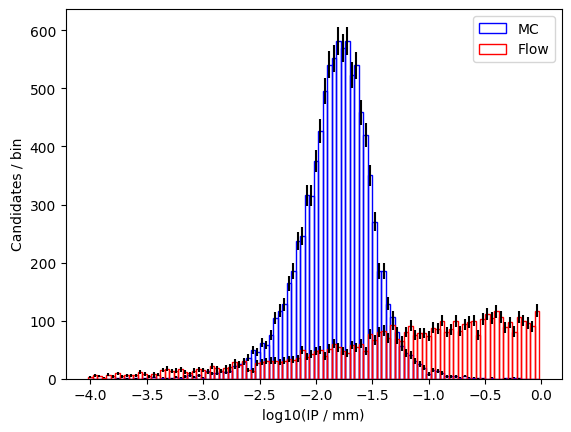

Loss at iteration 200: 0.7858882546424866


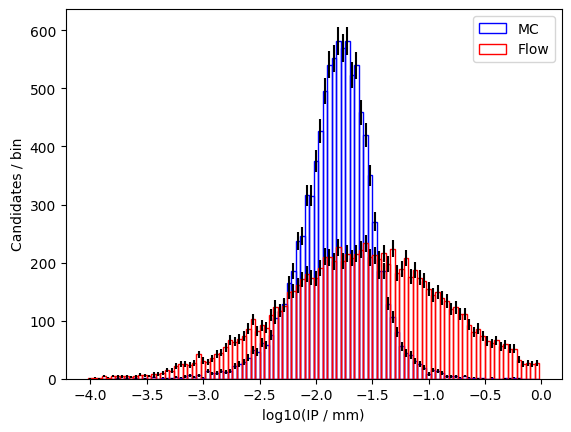

Loss at iteration 400: 0.3453862965106964


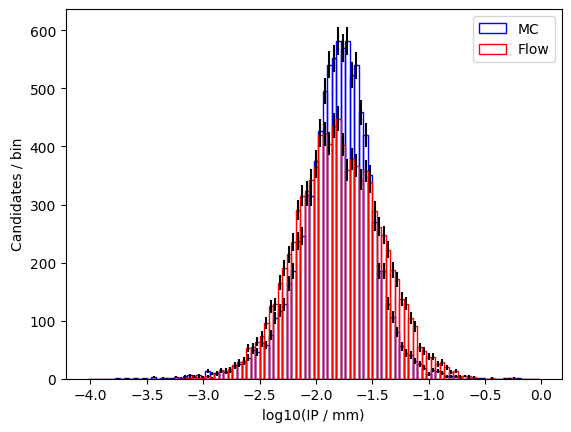

Loss at iteration 600: 0.3348950743675232


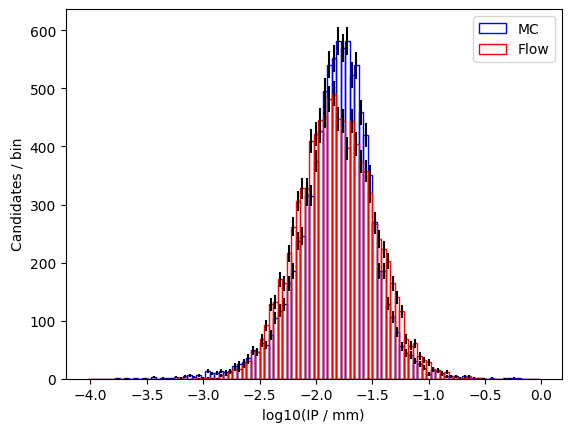

Loss at iteration 800: 0.33489471673965454


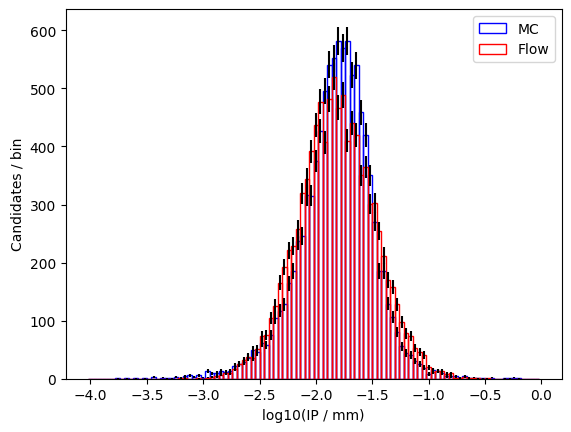

In [131]:
from torch import optim
optimizer = optim.Adam(flow.parameters())
n_iter = 1000
for i in range(n_iter):
    #flow.train() # Put it in training mode.

    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=sim_log10_ip_tensor).mean()
    loss.backward()
    optimizer.step()

    ### Testing the thing
    # flow.eval() # Put it in evaluation mode.
    with torch.inference_mode():
        if i % (n_iter/5) == 0:
            print(f"Loss at iteration {i}: {loss}")

            # Plot the target
            fig, ax = plt.subplots()
            #hist_mc, bins = np.histogram(sim_log10_ip, bins=100, range=(-4, 0))
            #bin_centers = (bins[:-1] + bins[1:]) / 2
            # Already did all that above
            ax.bar(x=bins[:-1], height=hist_mc, yerr=np.sqrt(hist_mc), width=bins[1] - bins[0], label='MC', fill=False, edgecolor='blue')
            ax.set_xlabel('log10(IP / mm)')
            ax.set_ylabel('Candidates / bin')

            # Sample from the flow and plot the histogram
            samples = flow.sample(N_SAMPLES)
            pred_hist, bins = np.histogram(samples, bins=100, range=(-4, 0))
            ax.bar(x=bins[:-1], height=pred_hist, yerr=np.sqrt(pred_hist), width=bins[1] - bins[0], label='Flow', fill=False, edgecolor='red')

            ax.legend()
            plt.show()

This works quite well, although not sufficiently well.

My first thought was "Surely this flow can do better", and so I started to think first about the loss function, and how it might not be appropriate.

How about we just train a little longer... 

Let's first functionize this a bit, so I'm not duplicating code.

In [132]:
def train_flow(flow, optimizer, target_data, n_iter, xrange=(-4, 0)):
    binning = dict(bins=100, range=xrange)
    
    # Setup the plot
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))
    ax = ax.flatten() 
    i_fig = 0
    # Plot the target
    hist_target, bins = np.histogram(target_data, **binning)

    # Start training and adding to the plot periodically
    for i in range(n_iter+1):
        optimizer.zero_grad()
        loss = -flow.log_prob(inputs=target_data).mean()
        loss.backward()
        optimizer.step()
        ### Testing the thing
        with torch.inference_mode():
            if i % (n_iter/5) == 0:
                print(f"Loss at iteration {i}: {loss}")
                ax[i_fig].set_title(f"Iteration {i}: Loss = {loss:.5f}")
                ax[i_fig].bar(x=bins[:-1], height=hist_target, yerr=np.sqrt(hist_target), width=bins[1] - bins[0], label='MC', fill=False, edgecolor='blue')
                ax[i_fig].set_xlabel('log10(IP / mm)')
                ax[i_fig].set_ylabel('Candidates / bin')

                # Sample from the flow and plot the histogram
                samples = flow.sample(N_SAMPLES)
                pred_hist, bins = np.histogram(samples, **binning)
                ax[i_fig].bar(x=bins[:-1], height=pred_hist, yerr=np.sqrt(pred_hist), width=bins[1] - bins[0], label='Flow', fill=False, edgecolor='red')

                ax[i_fig].legend()
        
                i_fig+=1

    plt.show()

Loss at iteration 0: 0.33489471673965454
Loss at iteration 400: 0.33489471673965454
Loss at iteration 800: 0.33489471673965454
Loss at iteration 1200: 0.33489471673965454
Loss at iteration 1600: 0.33489471673965454
Loss at iteration 2000: 0.33489468693733215


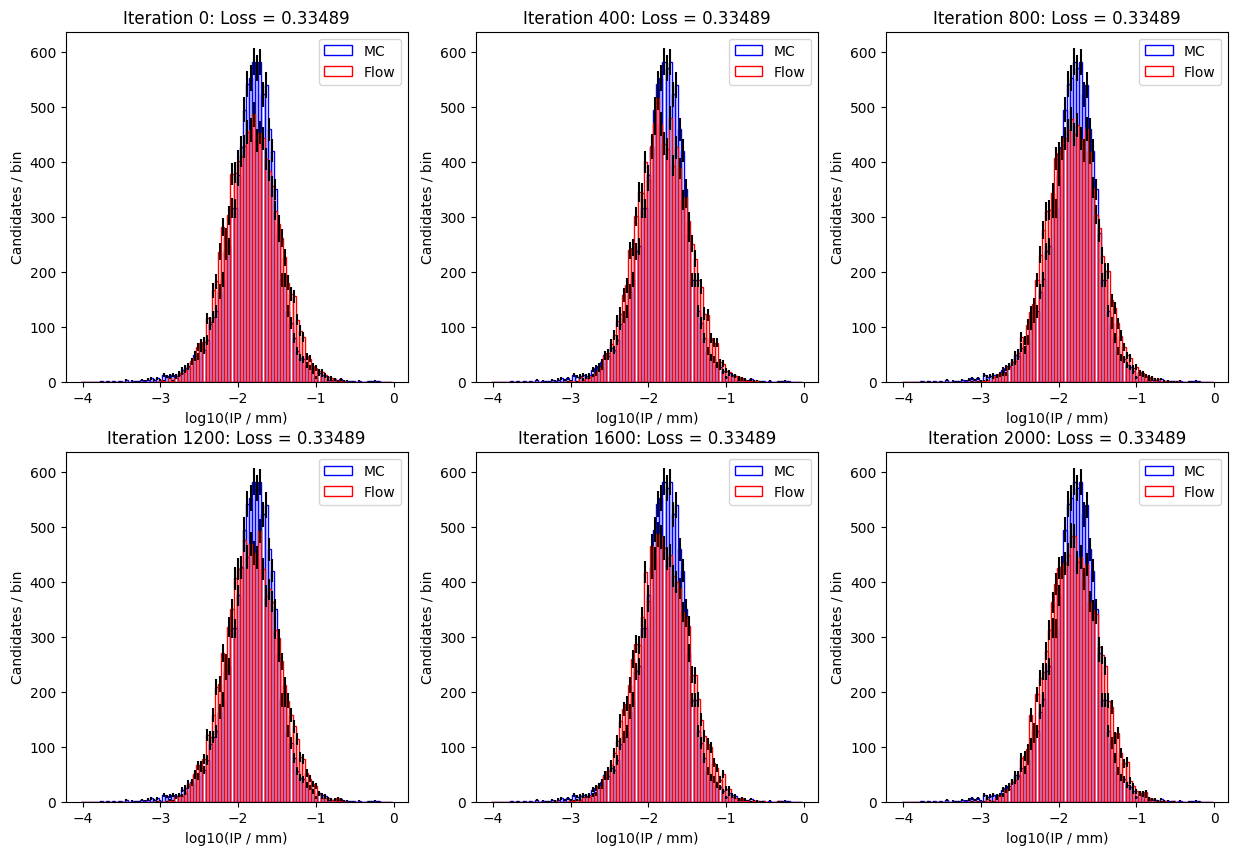

In [133]:
train_flow(flow, optimizer, sim_log10_ip_tensor, 2000)

So we can see, with the same flow, it's not getting better with more training. I could of course plot a loss curve, but there's really no need - I can see it by eye.

### Thoughts on the loss function and optimizer

Currently training with an Adam optimizer and the loss is `-flow.log_prob(inputs=sim_log10_ip_tensor).mean()`. I think something like a chi2 is a better suited loss/metric with which to optimise the flow (as this is what I'm used to - it does the trick for comparing one histogrammed distribution to another), but we first have to understand a bit more about what the loss function has to look like, and what this current loss function is and why it has been picked. 

* *What it currently is*:
    What is actually being calculated seems to the KL divergence, as described in eqn 14 of [the NFlows paper](https://arxiv.org/pdf/1912.02762). We can see that the `_log_prob` method (see code [here](https://github.com/bayesiains/nflows/blob/master/nflows/flows/base.py#L49)) of a flow evaluates a log of the probabilities for all the inputs you give it. log(prob) for a Gaussian is the Gaussian's exponent i.e. `(x - mu / 2 sigma**2 )**2`. We see something like that happening in the `StandardNormal`'s `_log_prob` function [here](https://github.com/bayesiains/nflows/blob/master/nflows/distributions/normal.py#L23). 
    Then we complete eqn 14 from the paper by taking this sum of log probabilities over the inputs and turning it into a mean.  

The flow is not really improving... Perhaps we tweak the parameters of the optimizer... It has a [default learning rate](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) of 0.001. Now that we are near the solution, perhaps we keep going but with a slower learning rate...

In [134]:
# Functionize the definition of the flow
def make_example_flow(hidden_features=4):
    N_FEATURES = 1
    transform = transforms.CompositeTransform([
        transforms.MaskedAffineAutoregressiveTransform(features=N_FEATURES, hidden_features=hidden_features),
        transforms.RandomPermutation(features=N_FEATURES)
    ])
    return flows.Flow(transform=transform, distribution=distributions.StandardNormal(shape=[N_FEATURES]))

Loss at iteration 0: 1.6655462980270386


Loss at iteration 200: 0.33489471673965454
Loss at iteration 400: 0.3348946273326874
Loss at iteration 600: 0.33489471673965454
Loss at iteration 800: 0.33489465713500977
Loss at iteration 1000: 0.3349640667438507


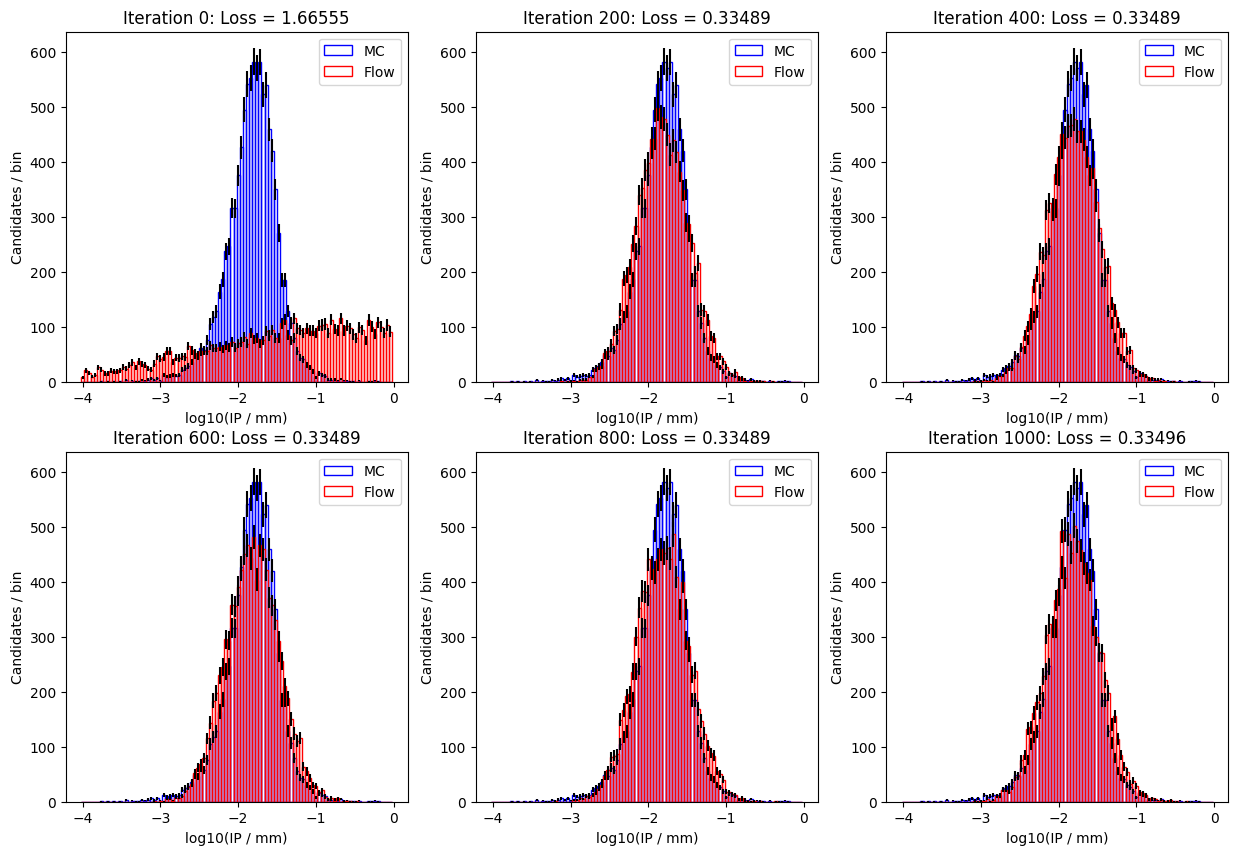

Loss at iteration 0: 1.9902738332748413
Loss at iteration 200: 1.97025728225708
Loss at iteration 400: 1.9510986804962158
Loss at iteration 600: 1.9327260255813599
Loss at iteration 800: 1.9150718450546265
Loss at iteration 1000: 1.8980695009231567


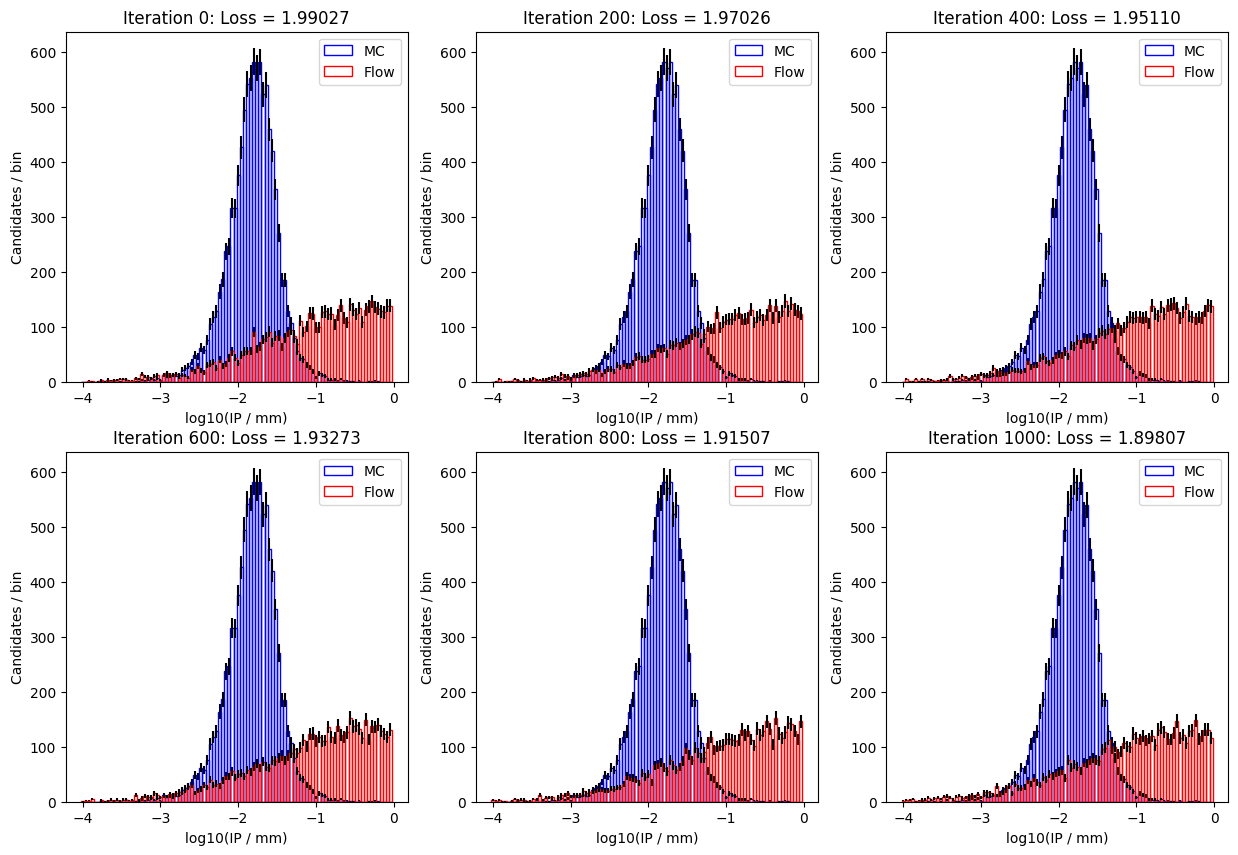

In [135]:
for lr in [1e-2, 1e-5]:
    basic_flow = make_example_flow()
    optimizer = optim.Adam(basic_flow.parameters(), lr=lr)
    train_flow(basic_flow, optimizer, sim_log10_ip_tensor, 1000)

So we see that a higher learning rate gets there a little quicker, and a slower one doesn't get there. 

But ultimately, we are struggling to shift from the same minimum that is being found.

In that case I think we do have to define a chi2 loss function.

### Chi2 loss function

To work out a chi2, I need to histogram the data. 

Here I rattled around for a while trying to histogram in a PyTorch-friendly way and train the flow based on a binned chi2.

I was unsuccessful, and the last attempt fails, so the call is commented out.


In [136]:
# def chi2_loss(y_true: np.histogram, y_pred: np.histogram):
#     return torch.sum((y_true - y_pred)**2 / y_true)

# Working out how to get histograms...
hist_sample = flow.sample(N_SAMPLES)
pred_hist = torch.histc(hist_sample,
                         bins=100,
                         min=-4,
                            max=0)
print(pred_hist)
print(type(pred_hist))

# torch.histogram provides an awkward return type, so we'll use torch.histc instead
# pred_hist2 = torch.histogram(hist_sample, bins=100, range=(-4, 0)) 
pred_hist2 = torch.histc(flow.sample(N_SAMPLES), bins=100, min=-4, max=0)
#print(pred_hist2)
# print(type(pred_hist))

#pred_hist2 = torch.histc(flow.sample(N_SAMPLES), bins=100, range=(-4, 0))
# print(pred_hist2)
# These two histos are indeed different thanks to the random sampling

# Can we subtract them?
resid = pred_hist - pred_hist2
print(resid)
#torch.sub(pred_hist, pred_hist2)
#print(pred_hist)

# pred_hist_tensor = torch.Tensor(pred_hist)
# print(pred_hist_tensor)

# plt.bar(x=bins[:-1],
#        height=pred_hist,
#        yerr=torch.sqrt(pred_hist),
#        width=bins[1] - bins[0],
#        label='Flow',
#        fill=False,
#        edgecolor='red')
# plt.show()

tensor([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   2.,   1.,   2.,   3.,   7.,   8.,   6.,  12.,  19.,  13.,  32.,
         44.,  64.,  64.,  83., 122., 127., 145., 206., 204., 268., 295., 285.,
        357., 381., 372., 429., 465., 449., 454., 524., 483., 434., 449., 395.,
        397., 354., 313., 269., 267., 217., 192., 152., 135., 108.,  95.,  69.,
         54.,  39.,  29.,  31.,  22.,  19.,  10.,  12.,   3.,   3.,   0.,   3.,
          1.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.])
<class 'torch.Tensor'>
tensor([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  -1.,   0.,   0.,
          0.,   1.,   1.,  -1.,  -4.,   3.,   3.,  -1.,   0.,  -6.,  -5.,  -2.,
          6.,  10., -12.,  -9.,   4., -19.,   2.,  39., -10.,   

In [137]:
def chi2_loss(y_true, y_pred):
    # First histogram the data
    pred_hist = torch.histc(y_pred, bins=100, min=-4, max=0)
    true_hist = torch.histc(y_true, bins=100, min=-4, max=0)
    return torch.sum((true_hist - pred_hist)**2 / true_hist)

In [138]:
def train_flow_with_chi2_loss(flow, optimizer, target_data, n_iter):
    #flow.train() # Put it in training mode.
    for i in range(n_iter):
        optimizer.zero_grad()
        pred_data = flow.sample(target_data.shape[0])
        loss = chi2_loss(target_data, pred_data)
        loss.backward()
        optimizer.step()
        ### Testing the thing
        # flow.eval() # Put it in evaluation mode.
        with torch.inference_mode():
            if i % (n_iter/5) == 0:
                print(f"Loss at iteration {i}: {loss}")

                # Plot the target
                fig, ax = plt.subplots()
                hist_target, bins = np.histogram(target_data, bins=100, range=(-4, 0))

                ax.bar(x=bins[:-1], height=hist_target, yerr=np.sqrt(hist_target), width=bins[1] - bins[0], label='MC', fill=False, edgecolor='blue')
                ax.set_xlabel('log10(IP / mm)')
                ax.set_ylabel('Candidates / bin')

                pred_hist, bins = np.histogram(pred_data, bins=100, range=(-4, 0))
                ax.bar(x=bins[:-1], height=pred_hist, yerr=np.sqrt(pred_hist), width=bins[1] - bins[0], label='Flow', fill=False, edgecolor='red')

                ax.legend()
                plt.show()

In [139]:
flow = make_example_flow()
n_iter = 1000
optimizer = optim.Adam(flow.parameters())
#train_flow(flow, optimizer, sim_log10_ip_tensor, n_iter)

We seem to be struggling. To be fair, you have to remember that this is all a neural network under-the-hood, and so histogramming those data points that go into
it is a bit weird. 

We could indeed histogram the data to plot it, and as part of testing evaluate a *test chi2*, but I think we need a loss function that is unbinned. 

So perhaps the next question is: why is my thing not working? Maybe I just need more hidden features?

### Trying more layers and hidden features

Loss at iteration 0: 2.1706507205963135
Loss at iteration 200: 0.33489611744880676


Loss at iteration 400: 0.3348946273326874
Loss at iteration 600: 0.3348946273326874
Loss at iteration 800: 0.3348946273326874
Loss at iteration 1000: 0.3348946273326874


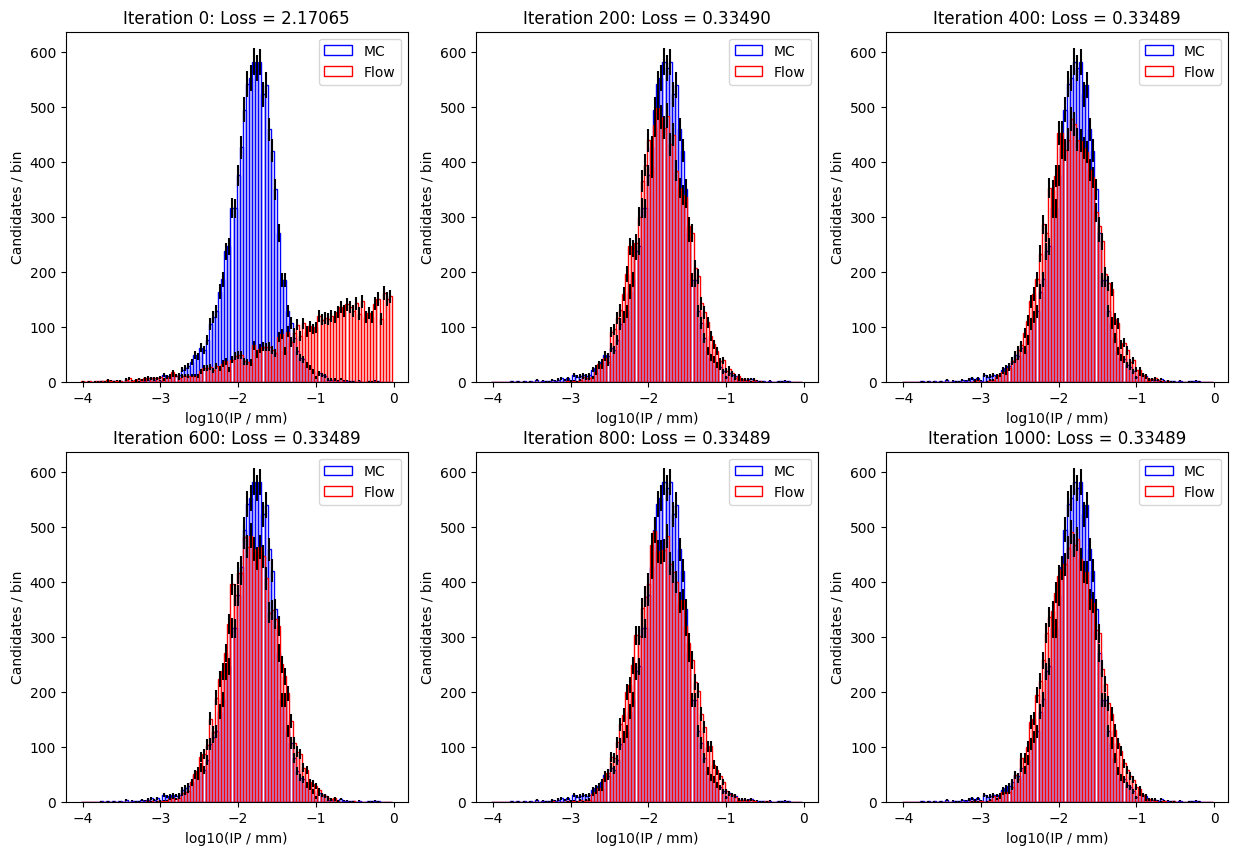

Loss at iteration 0: 2.2171106338500977
Loss at iteration 200: 0.33489781618118286
Loss at iteration 400: 0.33489471673965454
Loss at iteration 600: 0.3348946273326874
Loss at iteration 800: 0.33489471673965454
Loss at iteration 1000: 0.33489471673965454


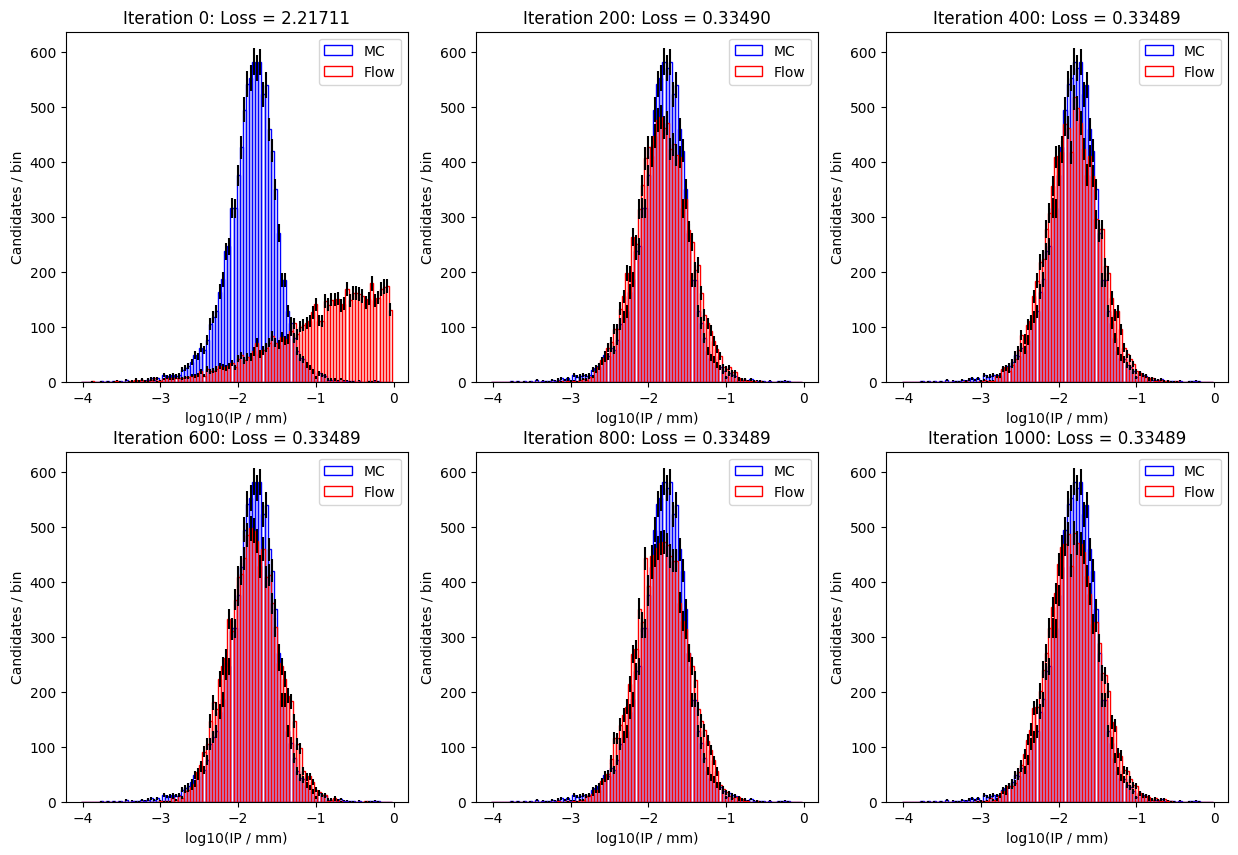

In [140]:
for n_hidden in [8, 16]:
    flow_v2 = make_example_flow(hidden_features=16)
    optimizer = optim.Adam(flow_v2.parameters())
    train_flow(flow_v2, optimizer, sim_log10_ip_tensor, n_iter)

So, seems that the number of hidden features isn't really making a difference...
The loss function underneath all this is not binned of course. How does this loss function work?

Reading the paper some more, maybe I start to see it. The KL divergence works by taking the sample from the target, applying the inverse transformation to them,
and evaluating the probability of each of those points as described by the base distribution. So for a Standard Normal, if the forward trans is good, the inverse will al so be good, and you'll get back a good sampling of a standard normal disribution, with probabilities between 0 and 1. It takes the log (thereby transform the [0,1] range to a roughly symmetric range about 0) and takes the mean. In the end, I think the KL divergence should therefore head towards 0. 

But then this makes sense why it might get the *width* wrong: if you think about it it only really gets the mean right. If we have a larger width we just get a bigger symmetric spread about 0 in log (prob) - the mean is still 0. So to first order I reckon this KL divergence can't really be expected to get the variance of the target distribution right. We need to try something else... 

In [141]:
def make_deep_flow(hidden_features=4, num_layers=2):
    N_FEATURES = 1
    _transforms = []
    for _ in range(num_layers):
        _transforms.append(transforms.ReversePermutation(features=N_FEATURES))
        _transforms.append(transforms.MaskedAffineAutoregressiveTransform(features=N_FEATURES, hidden_features=hidden_features))
    transform = transforms.CompositeTransform(_transforms)
    base_distribution = distributions.StandardNormal(shape=[N_FEATURES])
    return flows.Flow(transform=transform, distribution=base_distribution)

In [142]:
# This one didn't work - I didnt set up the flow correctly
def make_different_flow(hidden_features=4):
    N_FEATURES = 1
    transform = transforms.CompositeTransform([
        transforms.MaskedPiecewiseLinearAutoregressiveTransform(features=N_FEATURES, hidden_features=hidden_features, num_bins=8),
        transforms.RandomPermutation(features=N_FEATURES)
    ])
    base_distribution = distributions.StandardNormal(shape=[N_FEATURES])
    return flows.Flow(transform=transform, distribution=base_distribution)

Loss at iteration 0: 2.611750841140747


Loss at iteration 200: 0.3348947763442993
Loss at iteration 400: 0.33489468693733215
Loss at iteration 600: 0.33489468693733215
Loss at iteration 800: 0.33489471673965454
Loss at iteration 1000: 0.33489471673965454


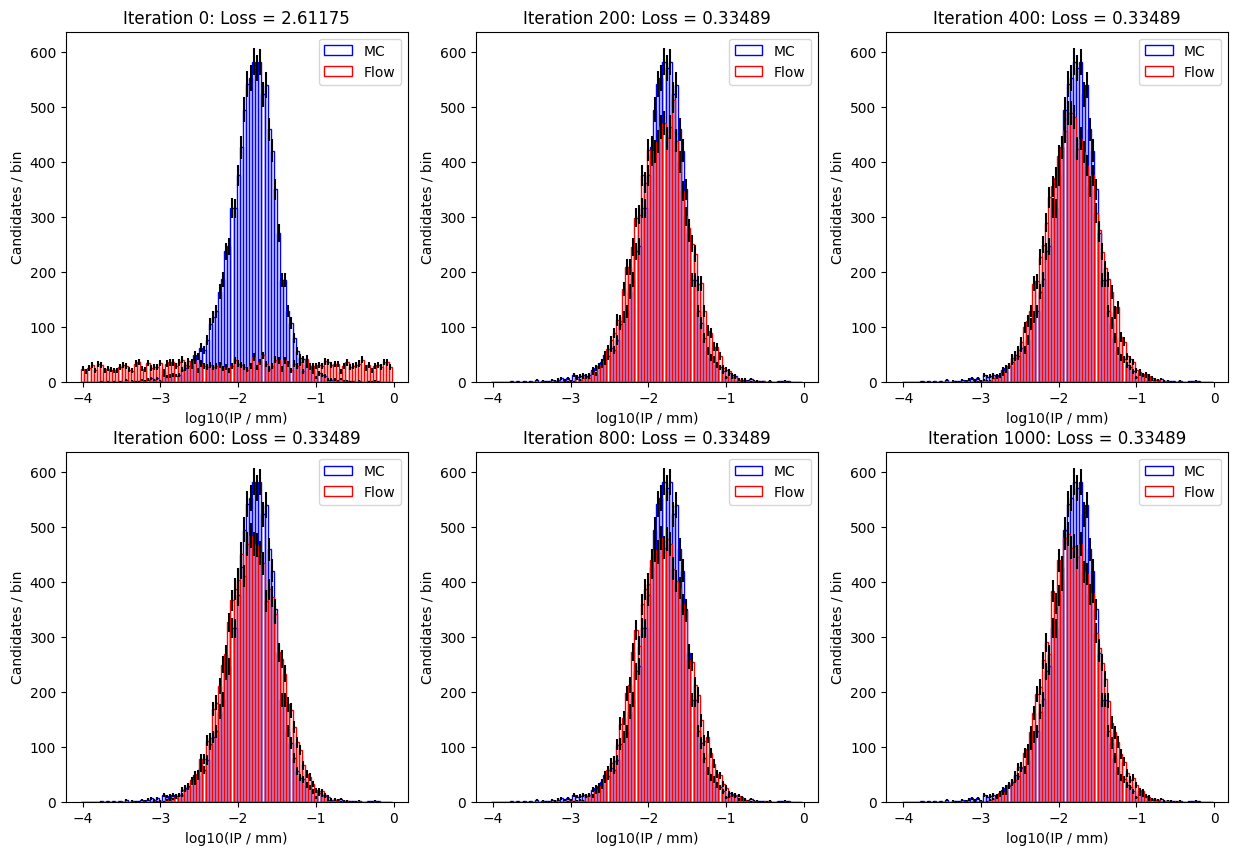

In [143]:
# deep_flow = make_different_flow(hidden_features=8) 
deep_flow = make_deep_flow(hidden_features=8, num_layers=5)
optimizer = optim.Adam(deep_flow.parameters())
train_flow(deep_flow, optimizer, sim_log10_ip_tensor, n_iter)

So even with more layers, taking much longer to train, I still end up in the same place.

### Sanity check: does the flow work at all? 

Let's have a go at seeing if the flow can map to a different 1D Gaussian with sufficient accuracy (and a good chi2)

tensor([[ 8.4965],
        [11.4839],
        [17.6776],
        ...,
        [14.7895],
        [ 4.2620],
        [ 8.4301]])


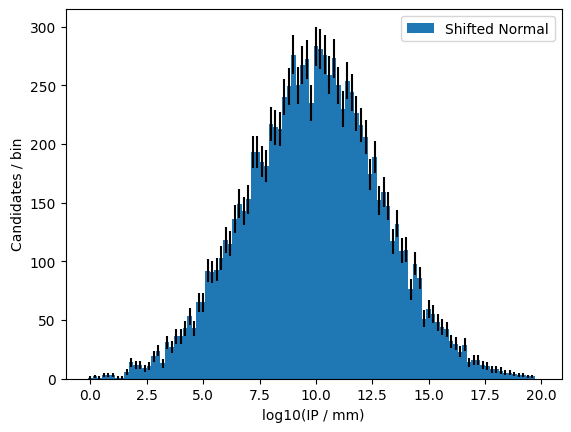

In [144]:
# Shift and scale a unit Gaussian
new_gaus = 3.0*distributions.StandardNormal(shape=[N_FEATURES]).sample(N_SAMPLES) + 10.0
print(new_gaus)

hist, new_bins = np.histogram(new_gaus, bins=100, range=(0, 20))
plt.bar(x=new_bins[:-1], height=hist, yerr=np.sqrt(hist), width=new_bins[1] - new_bins[0], label='Shifted Normal')
plt.xlabel('log10(IP / mm)')
plt.ylabel('Candidates / bin')
plt.legend()
plt.show()

Loss at iteration 0: 79.71395874023438
Loss at iteration 200: 4.79338264465332
Loss at iteration 400: 2.78682541847229
Loss at iteration 600: 2.7220940589904785
Loss at iteration 800: 2.6660871505737305
Loss at iteration 1000: 2.6204450130462646


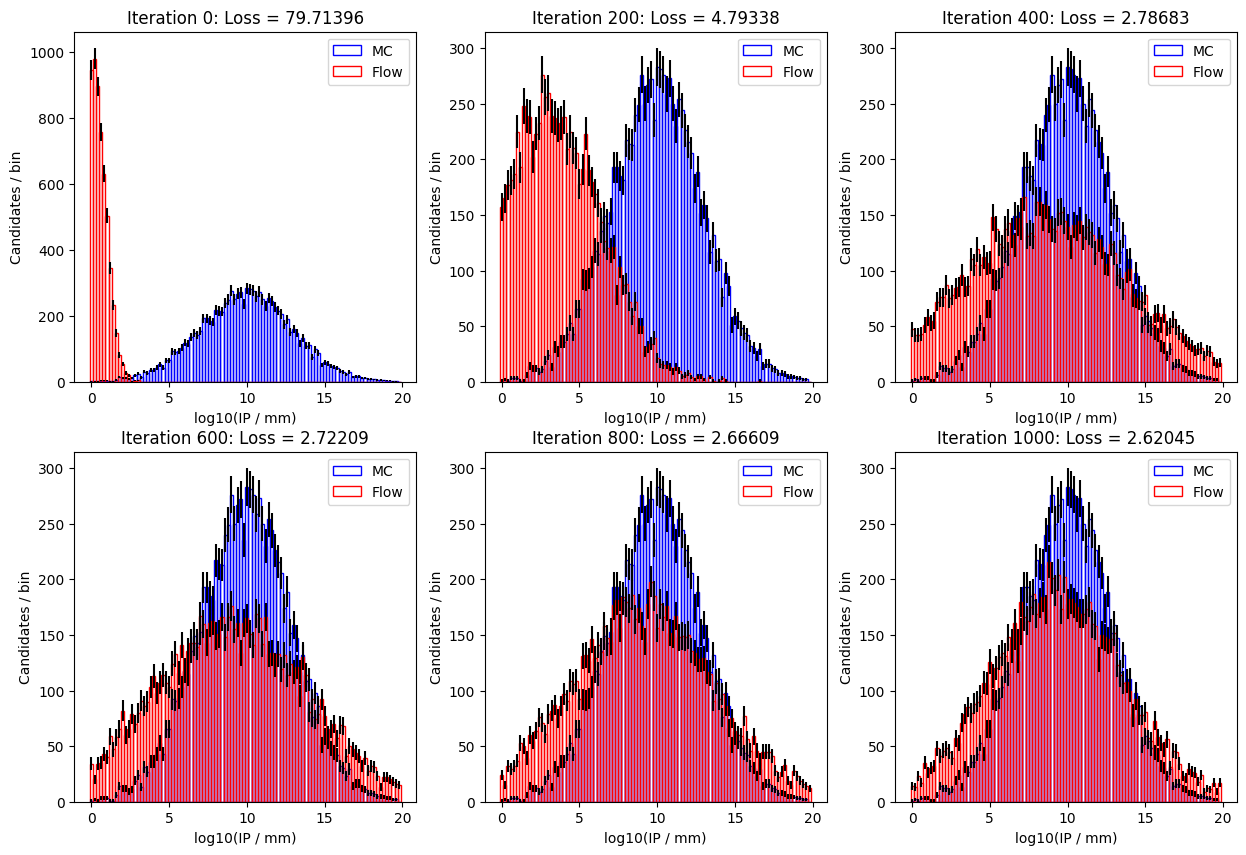

In [145]:
# Flow to it
old_flow = make_example_flow(hidden_features=4)
optimizer = optim.Adam(old_flow.parameters())
train_flow(old_flow, optimizer, new_gaus, n_iter, xrange=(0, 20))

It is getting there, although being a bit slow about it. Keep going...

Loss at iteration 0: 2.6202433109283447


Loss at iteration 200: 2.584956407546997
Loss at iteration 400: 2.5591185092926025
Loss at iteration 600: 2.541445016860962
Loss at iteration 800: 2.5303399562835693
Loss at iteration 1000: 2.524042844772339


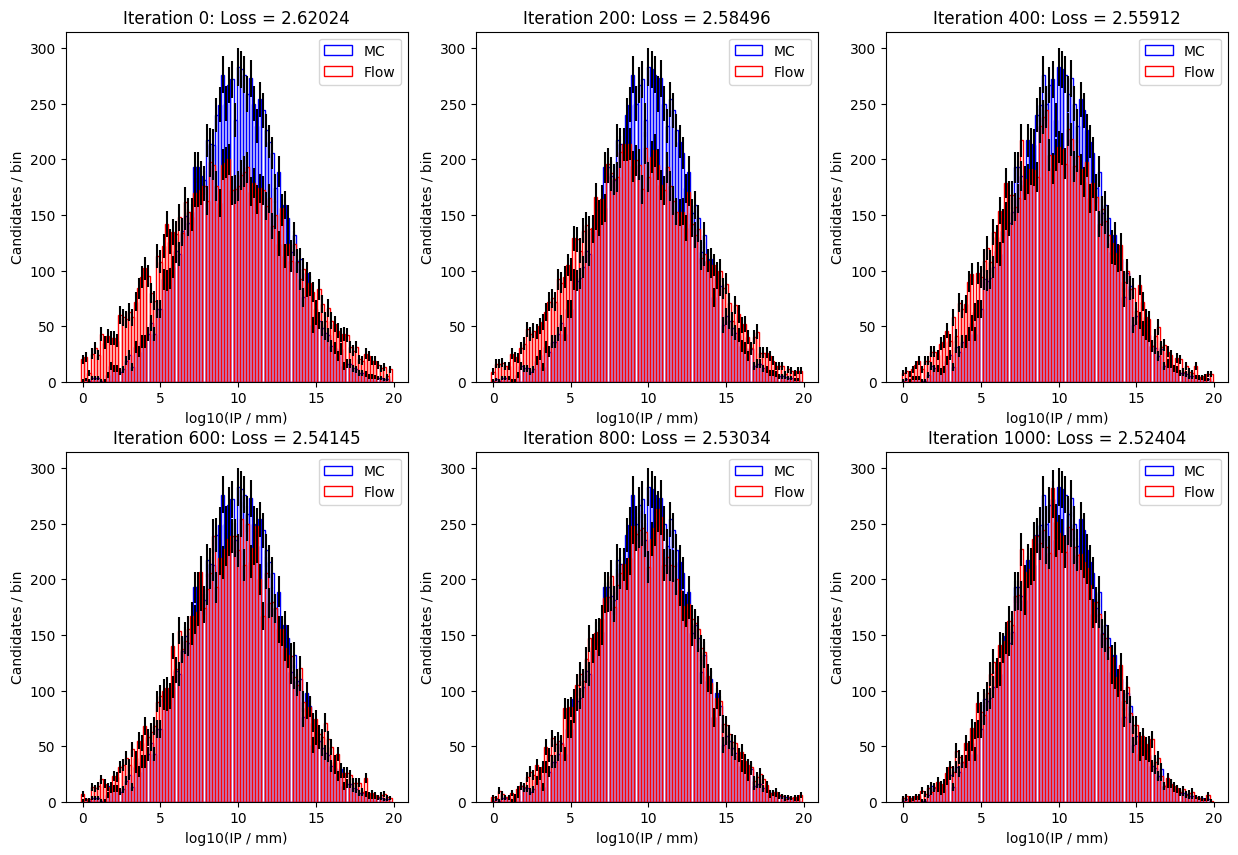

In [146]:
train_flow(old_flow, optimizer, new_gaus, n_iter, xrange=(0, 20))

That looks pretty good. Can we evaluate a chi2? And plot a pull and a ratio?

In [147]:
def benchmark_hep_style(flow, target, xrange=(0, 20)):
    # PLease use with torch.inference_mode

    # Divide the canvas into 2 vertically
    fig, ax = plt.subplots(3, 1, figsize=(6, 12))

    bin_opts = dict(bins=50, range=xrange)
    num_hist, bins = np.histogram(target, **bin_opts)

    samples = flow.sample(N_SAMPLES)
    pred_hist, bins = np.histogram(samples, **bin_opts)

    # Plot the two distributions
    ax[0].bar(x=bins[:-1], height=num_hist, yerr=np.sqrt(num_hist), width=bins[1] - bins[0], label='MC', fill=False)
    ax[0].bar(x=bins[:-1], height=pred_hist, yerr=np.sqrt(pred_hist), width=bins[1] - bins[0], label='Flow', fill=False, edgecolor='red', capsize=0)
    ax[0].legend()

    # Evaluate a chi2 - treat them as two independent distributions
    resid = np.where(np.isclose(num_hist, 0), 0, (num_hist - pred_hist)**2 / (np.abs(num_hist) + np.abs(pred_hist)))
    chi2 = np.sum(resid)
    nbins = len(num_hist)
    print(f"Chi2/nbins: {chi2}/{nbins} = {chi2/nbins}")
    
    ratio = num_hist / pred_hist
    ax[1].axhline(y=1, color='gray', linestyle='--')
    ax[1].errorbar(x=bins[:-1], y=ratio, yerr=np.sqrt((ratio**2 / np.abs(num_hist)) + (ratio**2/np.abs(pred_hist))), xerr=bins[1] - bins[0], label='Ratio', ls='')
    ax[1].set_ylim([0.5, 1.5])
    ax[1].set_ylabel('Ratio')

    # Calculate pull histogram
    pull = (num_hist - pred_hist) / np.sqrt(np.abs(num_hist) + np.abs(pred_hist))
    ax[2].bar(x=bins[:-1], height=pull, yerr=np.zeros_like(pull), width=bins[1] - bins[0], label='Pull', fill=True, edgecolor='blue')
    ax[2].set_ylabel('Pull')
    ax[2].set_ylim([-5 , 5])
    print(f"The sum of squared residuals is {np.sum(pull**2)}")
    ax[2].set_xlabel('log10(IP / mm)')

    plt.show()

Chi2/nbins: 82.33713239855302/50 = 1.6467426479710605
The sum of squared residuals is 82.33713239855302


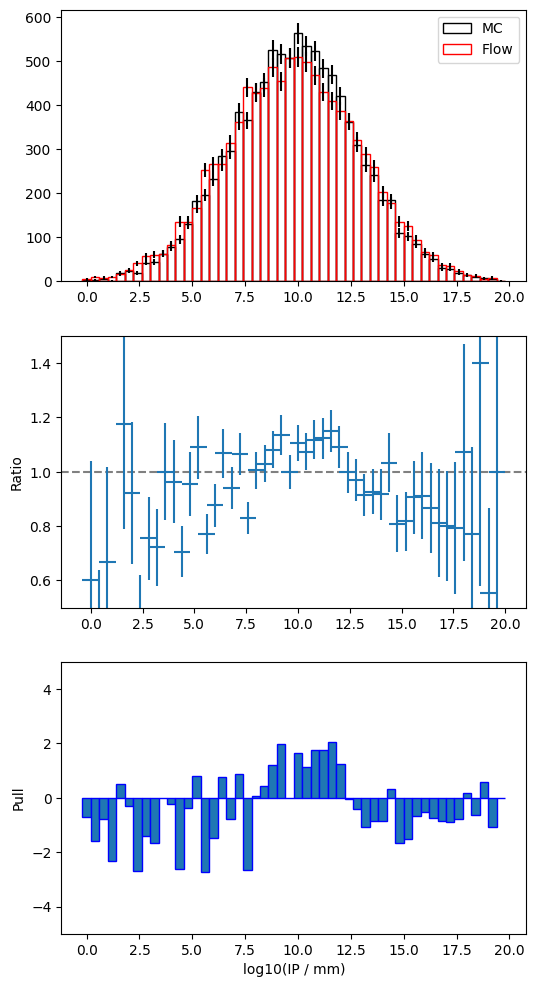

In [148]:
with torch.inference_mode():
    torch.manual_seed(50)
    benchmark_hep_style(old_flow, new_gaus)

So, looks like we can flow perfectly well to another Gaussian, but flowing to my not-quite-Gaussian is more tricky.
I probably need a different type of flow, one with more expressive power. I've already tried changing the learning rate, the number of hidden features as well.
Back to the paper I guess.

### Trying different types of flows

In [149]:
# Try a real NVP flow, which is supposed to be more expressive
def make_real_nvp_flow(hidden_features=8, num_layers=4, num_blocks_per_layer=2):
    N_FEATURES = 1
    return flows.SimpleRealNVP(features=N_FEATURES, hidden_features=hidden_features, num_layers=num_layers, num_blocks_per_layer=num_blocks_per_layer)

/home/epp/phrrkw/.local/lib/python3.9/site-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Loss at iteration 0: 1.6585901975631714
Loss at iteration 200: 0.9838050603866577
Loss at iteration 400: 0.9729021191596985
Loss at iteration 600: 0.9721333980560303
Loss at iteration 800: 0.9719319343566895
Loss at iteration 1000: 0.9718687534332275


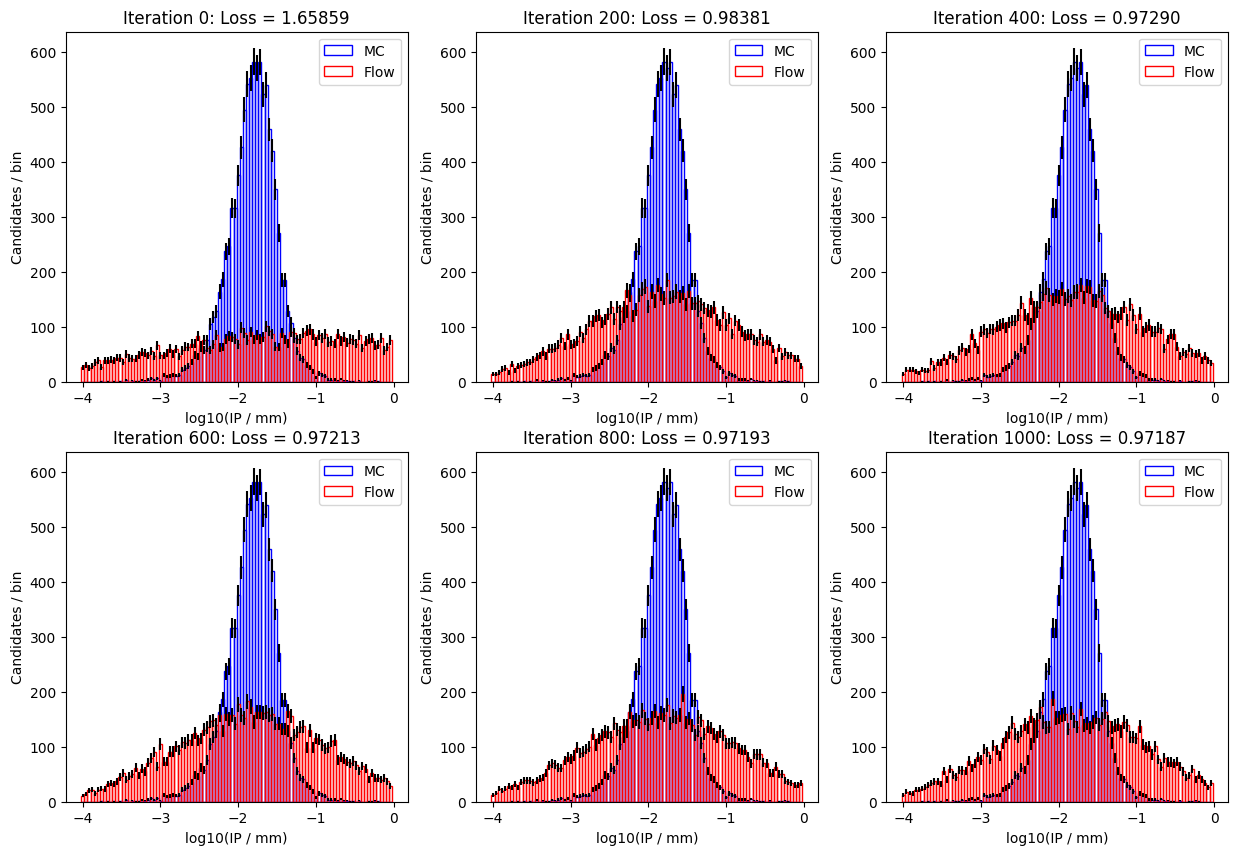

In [150]:
real_nvp_flow = make_real_nvp_flow(num_layers=10, hidden_features=8, num_blocks_per_layer=2)
optimizer = optim.Adam(real_nvp_flow.parameters())
train_flow(real_nvp_flow, optimizer, sim_log10_ip_tensor, n_iter=1000 )

# Tried:
# 8 hidden features, 4 layers, 2 blocks per layer, 1000 iters. Gets broad and flat and stuck at 0.97 
# and lr down to 0.01, 0.1 and 0.01 didnt do owt
# hidden features up to 16 made no difference
# with 10 layers it seems to be slowly improving... but only gets down to 0.972. Still broad and flat 
# 10 layers, 8 features did nowt


Reading this comment/issue https://github.com/bayesiains/nflows/issues/73 it seems my 1 MAF is indeed doomed, it's just a Gaussian -> Gaussian transform
The person there suggests a spline, and points to an abstract: https://papers.nips.cc/paper_files/paper/2019/hash/7ac71d433f282034e088473244df8c02-Abstract.html
They seem to suggest a monotonic rational-quadratic spline. 
THere seems to be a PiecewiseRationalQuadraticCDF in nflows, so let's try that

In [151]:
def make_quad_flow(hidden_features=8, num_layers=2):
    N_FEATURES = 1
    return flows.Flow(transform=transforms.PiecewiseRationalQuadraticCDF(shape=N_FEATURES, tails='linear', tail_bound=4, num_bins=3 ), distribution=distributions.StandardNormal(shape=[N_FEATURES]))

Loss at iteration 0: 4.764047145843506
Loss at iteration 2000: 0.2912912666797638
Loss at iteration 4000: 0.2765451669692993
Loss at iteration 6000: 0.2742026150226593
Loss at iteration 8000: 0.2738838493824005
Loss at iteration 10000: 0.27365225553512573


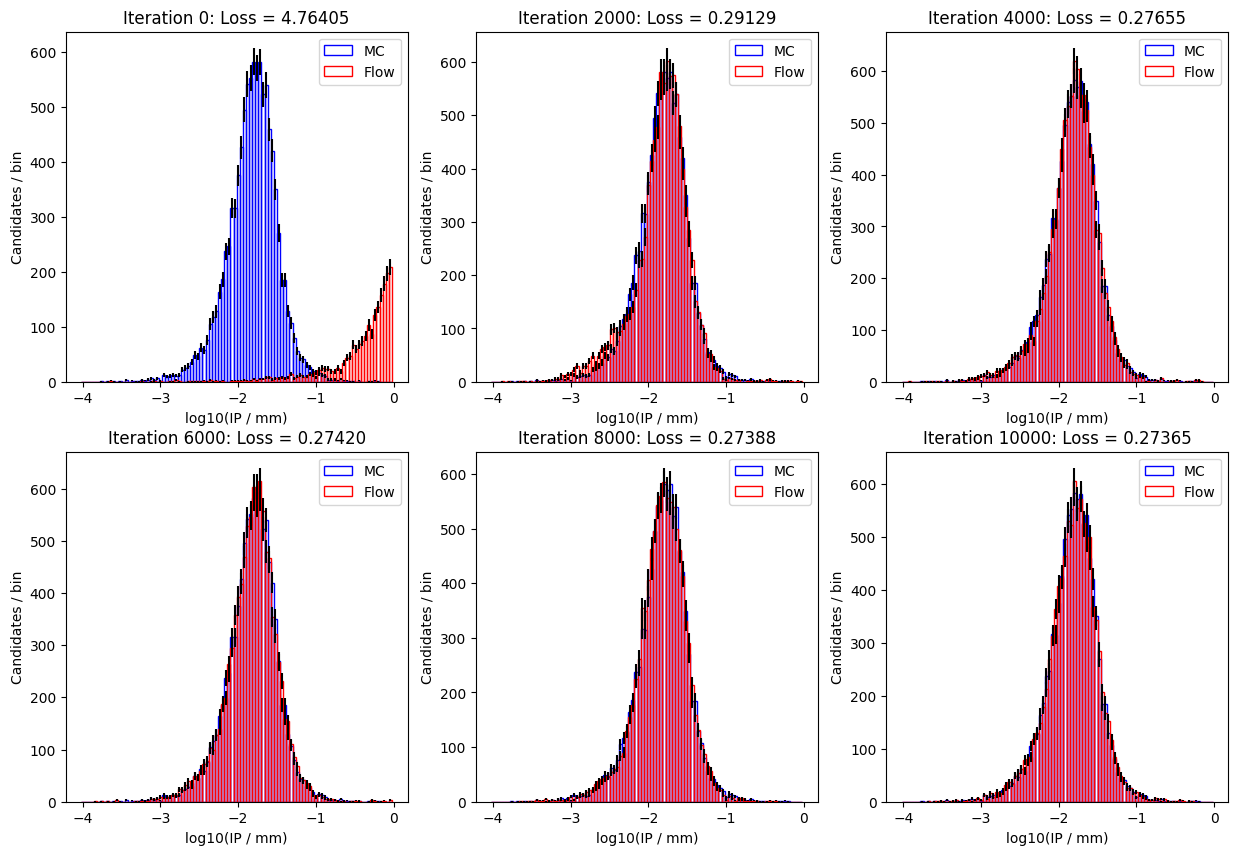

In [152]:
torch.manual_seed(50)
quad_flow = make_quad_flow()
optimizer = optim.Adam(quad_flow.parameters())
train_flow(quad_flow, optimizer, sim_log10_ip_tensor, n_iter=10000 )

It works!! Now we need to benchmark that hep style

/tmp/ipykernel_1648212/131204670.py:19: RuntimeWarning: invalid value encountered in divide
  resid = np.where(np.isclose(num_hist, 0), 0, (num_hist - pred_hist)**2 / (np.abs(num_hist) + np.abs(pred_hist)))
/tmp/ipykernel_1648212/131204670.py:24: RuntimeWarning: divide by zero encountered in divide
  ratio = num_hist / pred_hist
/tmp/ipykernel_1648212/131204670.py:24: RuntimeWarning: invalid value encountered in divide
  ratio = num_hist / pred_hist
/tmp/ipykernel_1648212/131204670.py:31: RuntimeWarning: invalid value encountered in divide
  pull = (num_hist - pred_hist) / np.sqrt(np.abs(num_hist) + np.abs(pred_hist))


Chi2/nbins: 47.746872063339694/50 = 0.9549374412667939
The sum of squared residuals is nan


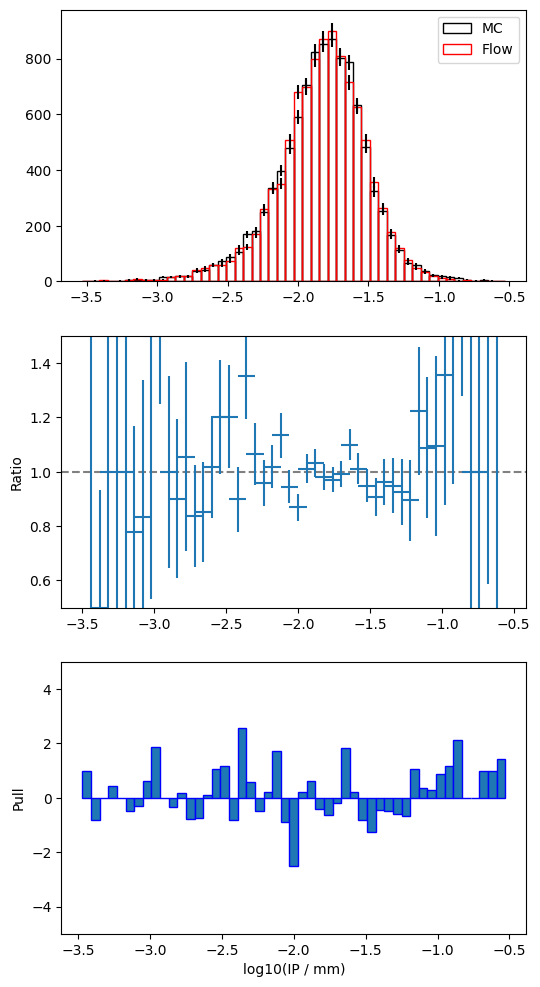

In [153]:
with torch.inference_mode():
    torch.manual_seed(50)
    benchmark_hep_style(quad_flow, sim_log10_ip_tensor, xrange=(-3.5, -0.5))

'Tis a thing of beauty. There is your first flow to the LHCb MC log10(IP) distribution.